<a href="https://colab.research.google.com/github/akpanitorobong/7135CEM-Modelling_and_Optimization_Under_Uncertainty/blob/main/7135_CEM_Task_1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Install Libraries**

In [2]:
print("Installing Libraries...")

# Install necessary packages
!pip install ucimlrepo  # For dataset handling
!pip install imbalanced-learn  # For class balancing

# mport Required Libraries
import pandas as pd  # For data manipulation
import numpy as np  # For numerical operations
import matplotlib.pyplot as plt  # For data visualization
import seaborn as sns  # Enhanced visualization
import time  # For tracking execution time

from ucimlrepo import fetch_ucirepo  # For dataset import

from imblearn.under_sampling import RandomUnderSampler# Class balancing

# Feature Scaling & Dimensionality Reduction
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

# Model Training & Evaluation
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV, RandomizedSearchCV
from sklearn.utils import resample
from sklearn.gaussian_process import GaussianProcessClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.svm import SVC

# Evaluation Metrics
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, classification_report, confusion_matrix

print("Libraries imported successfully!")

Installing Libraries...
Libraries imported successfully!


# **Load and Inspect Dataset**

In [3]:
# **Load and Inspect Dataset**
print("Loading dataset...")

# Fetch dataset from UCI Repository
cdc_diabetes_health_indicators = fetch_ucirepo(id=891)

# Extract features and target variables
X = cdc_diabetes_health_indicators.data.features
y = cdc_diabetes_health_indicators.data.targets

# Combine for easy data handling
df = pd.concat([X, y], axis=1)
df.to_csv('diabetes_health_indicators.csv', index=False)

print("Dataset loaded successfully.")
print("\nDataset Info:\n")
df.info()
print("\nFirst 5 Rows:\n")
df.head()

Loading dataset...
Dataset loaded successfully.

Dataset Info:

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 253680 entries, 0 to 253679
Data columns (total 22 columns):
 #   Column                Non-Null Count   Dtype
---  ------                --------------   -----
 0   HighBP                253680 non-null  int64
 1   HighChol              253680 non-null  int64
 2   CholCheck             253680 non-null  int64
 3   BMI                   253680 non-null  int64
 4   Smoker                253680 non-null  int64
 5   Stroke                253680 non-null  int64
 6   HeartDiseaseorAttack  253680 non-null  int64
 7   PhysActivity          253680 non-null  int64
 8   Fruits                253680 non-null  int64
 9   Veggies               253680 non-null  int64
 10  HvyAlcoholConsump     253680 non-null  int64
 11  AnyHealthcare         253680 non-null  int64
 12  NoDocbcCost           253680 non-null  int64
 13  GenHlth               253680 non-null  int64
 14  MentHlth            

,HighBP,HighChol,CholCheck,BMI,Smoker,Stroke,HeartDiseaseorAttack,PhysActivity,Fruits,Veggies,...,NoDocbcCost,GenHlth,MentHlth,PhysHlth,DiffWalk,Sex,Age,Education,Income,Diabetes_binary
0,1,1,1,40,1,0,0,0,0,1,...,0,5,18,15,1,0,9,4,3,0
1,0,0,0,25,1,0,0,1,0,0,...,1,3,0,0,0,0,7,6,1,0
2,1,1,1,28,0,0,0,0,1,0,...,1,5,30,30,1,0,9,4,8,0
3,1,0,1,27,0,0,0,1,1,1,...,0,2,0,0,0,0,11,3,6,0
4,1,1,1,24,0,0,0,1,1,1,...,0,2,3,0,0,0,11,5,4,0


# **Preprocessing**

In [4]:
# Remove unnecessary column if present
if "Unnamed: 0" in df.columns:
    df.drop(columns=["Unnamed: 0"], inplace=True)
    print("Column 'Unnamed: 0' removed.")

# Check for and remove duplicate rows
no_of_duplicates = df.duplicated().sum()
df = df.drop_duplicates()
print(f"Number of duplicate rows removed: {no_of_duplicates}")

Number of duplicate rows removed: 24206


# **Class Balancing**

In [5]:
# Define target variable
target_col = "Diabetes_binary"
X = df.drop(columns=[target_col])  # Features
y = df[target_col]  # Target variable

# Check class distribution before balancing
print("\nClass Distribution Before Balancing:")
print(y.value_counts(), "\n")

# Apply Random Undersampling to balance the dataset
undersampler = RandomUnderSampler(random_state=42)
X_resampled, y_resampled = undersampler.fit_resample(X, y)

# Convert back to DataFrame
df_balanced = pd.DataFrame(X_resampled, columns=X.columns)
df_balanced[target_col] = y_resampled  # Add target column back

print("Dataset balanced using Random Undersampling. \nNew class distribution:")
print(df_balanced[target_col].value_counts())


Class Distribution Before Balancing:
Diabetes_binary
0    194377
1     35097
Name: count, dtype: int64 

Dataset balanced using Random Undersampling. 
New class distribution:
Diabetes_binary
0    35097
1    35097
Name: count, dtype: int64


# **Visualization**

In [ ]:
 # Plot class distribution after balancing
plt.figure(figsize=(6, 4))
sns.barplot(x=df_balanced[target_col].value_counts().index,
            y=df_balanced[target_col].value_counts().values,
            palette="viridis", hue = df_balanced[target_col].value_counts().index)
plt.xlabel("Diabetes Class (0 = No Diabetes, 1 = Diabetes)")
plt.ylabel("Number of Samples")
plt.title("Class Distribution After Undersampling")
plt.show()

# Display the first few rows of the cleaned and processed dataset
df_balanced.head()

# **Standardization**

In [6]:
# Identify numerical columns (excluding categorical features)
num_cols = ["BMI", "MentHlth", "PhysHlth", "Age", "Education", "Income"]

# Standardize numerical features
scaler = StandardScaler()
df_balanced[num_cols] = scaler.fit_transform(df_balanced[num_cols])

print("Numerical features standardized.")
print("Rows affected: ", num_cols)

# Split dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(df_balanced.drop(columns=[target_col]),
                                                    df_balanced[target_col],
                                                    test_size=0.2,
                                                    random_state=42)

print("\nData split into training and testing sets.")

Numerical features standardized.
Rows affected:  ['BMI', 'MentHlth', 'PhysHlth', 'Age', 'Education', 'Income']

Data split into training and testing sets.


# **Feature Importance**

**Get Top Features**

In [7]:
print("\nCalculating Feature Importance using Random Forest...")

# Train a Random Forest model
rf = RandomForestClassifier(random_state=42)
rf.fit(X_train, y_train)

# Get feature importances
importances = rf.feature_importances_
feature_names = X_train.columns

# Create DataFrame for feature importance
feature_importance_df = pd.DataFrame({'Feature': feature_names, 'Importance': importances})
feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False)

# Select top N features (e.g., 10)
top_features = feature_importance_df.iloc[:10]['Feature'].values
X_train_FI = X_train[top_features]
X_test_FI = X_test[top_features]

# Display top 10 features
print("\nTop 10 Most Important Features:\n")
print(feature_importance_df.head(10))


Calculating Feature Importance using Random Forest...

Top 10 Most Important Features:

      Feature  Importance
3         BMI    0.171804
18        Age    0.128894
13    GenHlth    0.091159
20     Income    0.087525
0      HighBP    0.072561
15   PhysHlth    0.071282
19  Education    0.061510
14   MentHlth    0.053762
1    HighChol    0.039219
4      Smoker    0.030037


**Visualization**

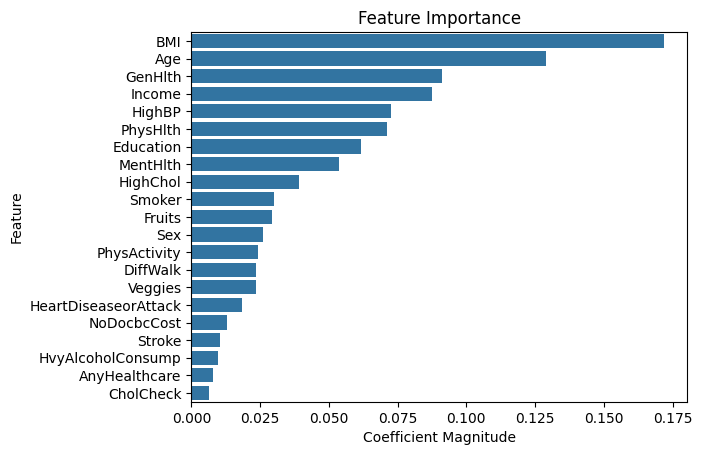

In [8]:
# Plot
sns.barplot(x=feature_importance_df.Importance, y=feature_importance_df.Feature)
plt.xlabel("Coefficient Magnitude")
plt.ylabel("Feature")
plt.title("Feature Importance")
plt.show()

# **PCA on FI**

**Perform PCA on important features**

In [9]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

# Standardize the features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_FI)
X_test_scaled = scaler.transform(X_test_FI)

# Apply PCA (you can specify n_components based on variance explained)
pca = PCA(n_components=0.95)  # Retain 95% of variance
X_train_pca_fi = pca.fit_transform(X_train_scaled)
X_test_pca_fi = pca.transform(X_test_scaled)

# Check explained variance
explained_variance = pca.explained_variance_ratio_
sum = 0
for i in explained_variance :
    sum= sum + i

print("Explained Variance Ratio:", explained_variance)
print("Variance sum:", sum)
print("Number of Components Selected:", pca.n_components_)

Explained Variance Ratio: [0.25887224 0.14098042 0.11527241 0.10151225 0.09041414 0.07649723
 0.06473804 0.05648534 0.05328981]
Variance sum: 0.9580618877837052
Number of Components Selected: 9


**Scree Plot**

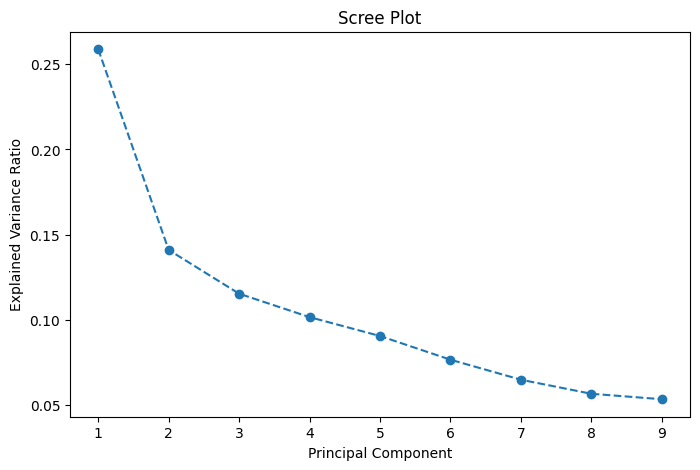

In [10]:
#Shows how much variance each principal component explains
plt.figure(figsize=(8,5))
plt.plot(range(1, len(explained_variance) + 1), explained_variance, marker='o', linestyle='--')
plt.xlabel('Principal Component')
plt.ylabel('Explained Variance Ratio')
plt.title('Scree Plot')
plt.show()

# **Principal Component Analysis**

In [11]:
from sklearn.decomposition import PCA
import numpy as np

# Fit PCA without limiting components
pca_full = PCA().fit(X_train)
print("Total components: " + str(pca_full.n_components_))

# Compute cumulative explained variance
cumulative_variance = np.cumsum(pca_full.explained_variance_ratio_)

# Find the number of components that retain at least 95% variance
n_components_95 = np.argmax(cumulative_variance >= 0.95) + 1  # +1 since index starts at 0
print(f"Number of components to retain 95% variance: {n_components_95}")

# Apply PCA with optimal number of components
pca = PCA(n_components=n_components_95)
X_train_pca = pca.fit_transform(X_train)
X_test_pca = pca.transform(X_test)

# Check total variance retained
total_variance_retained = np.sum(pca.explained_variance_ratio_)
print(f"Total variance retained: {total_variance_retained:.2f}")

Total components: 21
Number of components to retain 95% variance: 15
Total variance retained: 0.96


# **Model Training and Evaluation**


**Model and Dataset Definition**

In [12]:
# Define datasets
datasets = {
    "Original": (X_train, X_test),
    "Feature Importance": (X_train_FI, X_test_FI),
    "PCA": (X_train_pca, X_test_pca),
    "PCA + Feature Importance": (X_train_pca_fi, X_test_pca_fi)
}

# Define models
models = {
    "Gaussian Process Classifier": GaussianProcessClassifier(),
    "Logistic Regression": LogisticRegression(),
    "Random Forest": RandomForestClassifier(),
    "Support Vector Machine": SVC(probability=True),
    "Gradient Boosting Classifier": GradientBoostingClassifier()
}

# Store results
results = []

# Define sampling percentage for Gaussian Process Classifier due to computational needs
gpc_sample_pct = 0.10
print("\Models defined")


Training and Evaluating Models...


**Models Execution**

In [ ]:
# Iterate through datasets and models
for dataset_name, (X_tr, X_te) in datasets.items():
    for model_name, model in models.items():
        start_time = time.time()

        # If Gaussian Process Classifier, sample 10% of the data while keeping class balance
        if model_name == "Gaussian Process Classifier":
            X_tr_sampled, y_tr_sampled = resample(
                X_tr, y_train,
                replace=False,
                stratify=y_train,
                n_samples=int(len(X_tr) * gpc_sample_pct),
                random_state=42
            )
        else:
            X_tr_sampled, y_tr_sampled = X_tr, y_train

        # Train model
        model.fit(X_tr_sampled, y_tr_sampled)
        y_pred = model.predict(X_te)
        y_prob = model.predict_proba(X_te)[:, 1] if hasattr(model, "predict_proba") else None

        # Evaluate metrics
        accuracy = accuracy_score(y_test, y_pred)
        precision = precision_score(y_test, y_pred)
        recall = recall_score(y_test, y_pred)
        f1 = f1_score(y_test, y_pred)
        auc = roc_auc_score(y_test, y_prob) if y_prob is not None else None
        execution_time = time.time() - start_time

        # Store result
        results.append({
            "Model": f"{dataset_name} - {model_name}",
            "Accuracy": accuracy,
            "Precision": precision,
            "Recall": recall,
            "F1 Score": f1,
            "AUC-ROC": auc,
            "Time (s)": execution_time
        })

**Model Results**

In [ ]:
# Convert to DataFrame
results_df = pd.DataFrame(results)

# Save to CSV
results_df.to_csv("model_evaluation_results.csv", index=False)

print("Model evaluation complete. Results saved to 'model_evaluation_results.csv'.")

# **Results**

Model Performance Metrics:
                               Accuracy  Precision  Recall  F1-score   ROC-AUC  \
Gaussian Process Classifier     0.7515   0.728015   0.803  0.763671  0.799165   
Logistic Regression             0.7505   0.736544   0.780  0.757649  0.818801   
Random Forest                   0.7540   0.737383   0.789  0.762319  0.834365   
Support Vector Machine          0.7530   0.727110   0.810  0.766320  0.820730   
Gradient Boosting Classifier    0.7480   0.726277   0.796  0.759542  0.821637   

                                Time (s)  
Gaussian Process Classifier   200.439107  
Logistic Regression             0.086803  
Random Forest                   1.263047  
Support Vector Machine         18.320079  
Gradient Boosting Classifier    1.131432  


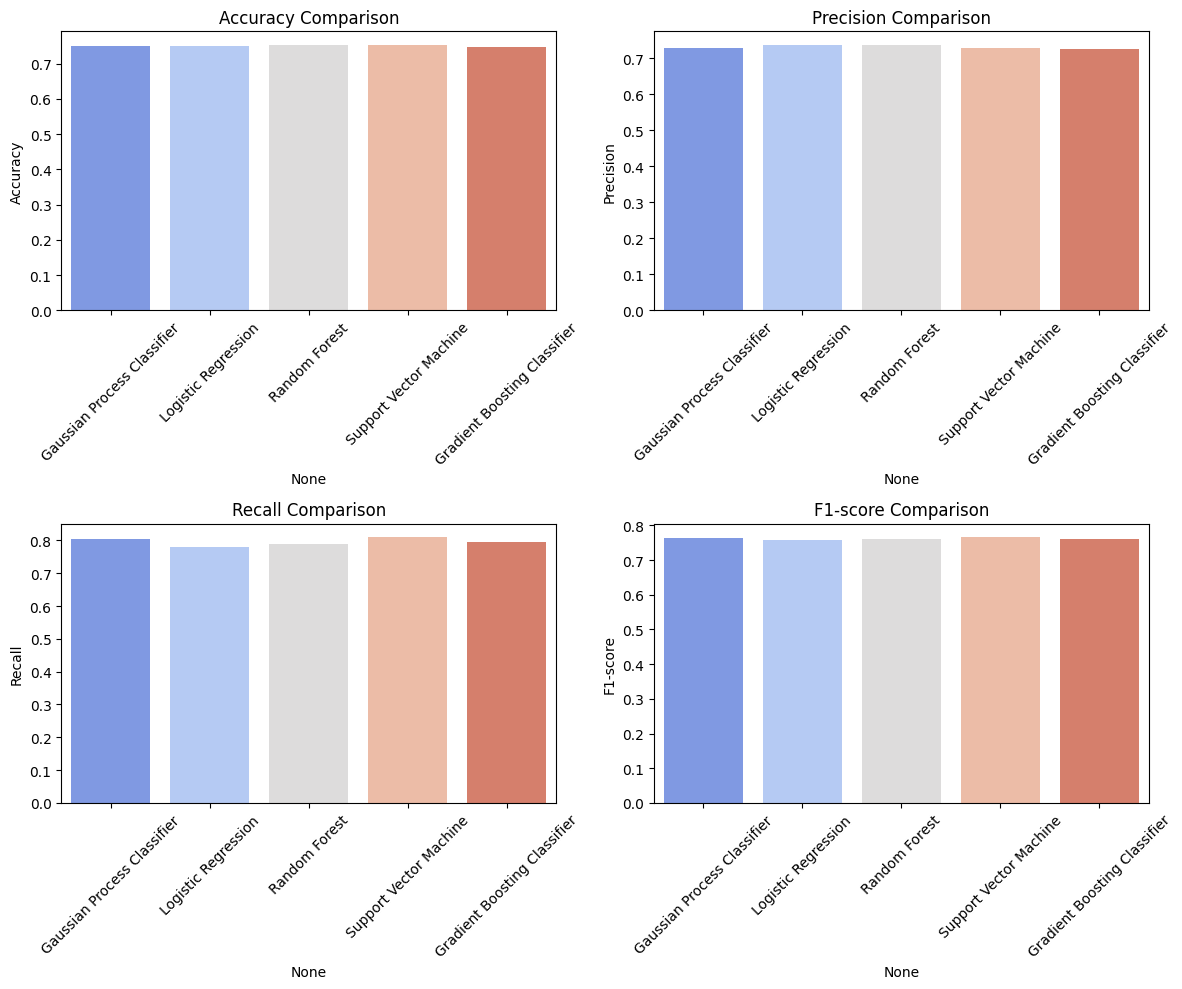


Classification Report for Gaussian Process Classifier:

              precision    recall  f1-score   support

           0       0.78      0.70      0.74      1000
           1       0.73      0.80      0.76      1000

    accuracy                           0.75      2000
   macro avg       0.75      0.75      0.75      2000
weighted avg       0.75      0.75      0.75      2000


Classification Report for Logistic Regression:

              precision    recall  f1-score   support

           0       0.77      0.72      0.74      1000
           1       0.74      0.78      0.76      1000

    accuracy                           0.75      2000
   macro avg       0.75      0.75      0.75      2000
weighted avg       0.75      0.75      0.75      2000


Classification Report for Random Forest:

              precision    recall  f1-score   support

           0       0.77      0.72      0.75      1000
           1       0.74      0.79      0.76      1000

    accuracy                     

In [ ]:
# Display results
print("Model Performance Metrics:\n", results_df)

# ------------------------- VISUALIZATION -------------------------

# Plot model performance
fig, axes = plt.subplots(2, 2, figsize=(12, 10))
axes = axes.flatten()
metrics = ["Accuracy", "Precision", "Recall", "F1-score"]

for i, metric in enumerate(metrics):
    sns.barplot(x=results_df.index, y=results_df[metric], ax=axes[i], hue=results_df.index, palette="coolwarm", legend=False)
    axes[i].set_title(f"{metric} Comparison")
    axes[i].set_ylabel(metric)
    axes[i].set_xticks(range(len(results_df.index)))
    axes[i].set_xticklabels(results_df.index, rotation=45)

plt.tight_layout()
plt.show()

# Display classification reports for each model
for name, model in models.items():
    print(f"\nClassification Report for {name}:\n")
    print(classification_report(y_test, model.predict(X_test)))

# **Hyperparmeter Tuning on Select Models(Gausian Process Classifier and Logistic Regression)**

In [ ]:
# Define hyperparameter grids
param_grid_gpc = {
    'max_iter_predict': [50, 100, 200],
    'multi_class': ['one_vs_rest']
}

param_grid_lr = {
    'C': [0.01, 0.1, 1, 10, 100],
    'solver': ['liblinear', 'lbfgs', 'saga']
}

# Hyperparameter tuning for Gaussian Process Classifier
gpc = GaussianProcessClassifier()
gpc_search = RandomizedSearchCV(gpc, param_grid_gpc, n_iter=5, cv=3, scoring='accuracy', random_state=42, n_jobs=-1)
gpc_search.fit(X_train, y_train)
best_gpc = gpc_search.best_estimator_
print("Best Parameters for Gaussian Process Classifier:", gpc_search.best_params_)

# Hyperparameter tuning for Logistic Regression
lr = LogisticRegression()
lr_search = RandomizedSearchCV(lr, param_grid_lr, n_iter=5, cv=3, scoring='accuracy', random_state=42, n_jobs=-1)
lr_search.fit(X_train, y_train)
best_lr = lr_search.best_estimator_
print("Best Parameters for Logistic Regression:", lr_search.best_params_)

# Evaluate tuned models
def evaluate_model(model, X_test, y_test):
    y_pred = model.predict(X_test)
    y_pred_proba = model.predict_proba(X_test)[:, 1]
    return {
        "Accuracy": accuracy_score(y_test, y_pred),
        "Precision": precision_score(y_test, y_pred),
        "Recall": recall_score(y_test, y_pred),
        "F1-score": f1_score(y_test, y_pred),
        "ROC-AUC": roc_auc_score(y_test, y_pred_proba)
    }

# Store results
results_tuned = {
    "Gaussian Process Classifier (Tuned)": evaluate_model(best_gpc, X_test, y_test),
    "Logistic Regression (Tuned)": evaluate_model(best_lr, X_test, y_test)
}

# Convert results to DataFrame
results_tuned_df = pd.DataFrame(results_tuned).T
print("Tuned Model Performance:\n", results_tuned_df)

# **Post-Tuning Results**

In [ ]:
print (results_df, "\n\n",results_tuned_df)

                              Accuracy  Precision  Recall  F1-score   ROC-AUC  \
Gaussian Process Classifier     0.7515   0.728015   0.803  0.763671  0.799165   
Logistic Regression             0.7505   0.736544   0.780  0.757649  0.818801   
Random Forest                   0.7540   0.737383   0.789  0.762319  0.834365   
Support Vector Machine          0.7530   0.727110   0.810  0.766320  0.820730   
Gradient Boosting Classifier    0.7480   0.726277   0.796  0.759542  0.821637   

                                Time (s)  
Gaussian Process Classifier   200.439107  
Logistic Regression             0.086803  
Random Forest                   1.263047  
Support Vector Machine         18.320079  
Gradient Boosting Classifier    1.131432   

                                      Accuracy  Precision  Recall  F1-score  \
Gaussian Process Classifier (Tuned)    0.7515   0.728015   0.803  0.763671   
Logistic Regression (Tuned)            0.7495   0.736493   0.777  0.756204   

                 